In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

In [141]:
def anomaly(dato,obs):
    climatologia = obs.mean(dim='time')
    anomalia = dato.mean(dim='time') - climatologia
    return climatologia, anomalia


In [6]:
#Datos-----------------------------------------------------------------
path = '/home/tabu/Escritorio/Doctorado/ClimDinam/TP2/'
path2 = '/media/tabu/JULIAexterno/climatologia_dinamica/'

#Abro CanESM2
CanESM2_ens = xr.open_dataset(path2+'CanESM2/pr_Amon_CanESM2_historical_ensmean_197601-200512_2.5_mes.nc')

#Abro CanESM5
CanESM5_ens = xr.open_dataset(path2+'CanESM5/pr_Amon_CanESM5_historical_ensmean1p1f1_2.5_mes.nc')

In [111]:

#Monzón HS
def annual_range_HS(dato):
    verano = dato.sel(time=dato['time.season']=='DJF').mean(dim='time').pr
    invierno = dato.sel(time=dato['time.season']=='JJA').mean(dim='time').pr
    primavera = dato.sel(time=dato['time.season']=='SON').mean(dim='time').pr
    otono = dato.sel(time=dato['time.season']=='MAM').mean(dim='time').pr
    anual = verano + primavera + invierno + otono
    porcentaje_verano = verano/anual
    rango = (verano-invierno)*3
    return rango, porcentaje_verano

#Monzón HN
def annual_range_HN(dato):
    verano = dato.sel(time=dato['time.season']=='JJA').mean(dim='time').pr
    invierno = dato.sel(time=dato['time.season']=='DJF').mean(dim='time').pr
    primavera = dato.sel(time=dato['time.season']=='MAM').mean(dim='time').pr
    otono = dato.sel(time=dato['time.season']=='SON').mean(dim='time').pr
    anual = verano + primavera + invierno + otono
    porcentaje_verano = verano/anual
    rango = (verano-invierno)*3
    return rango, porcentaje_verano


In [203]:
def mapa(dato1,dato2,titulo):
    #America del sur -------Observaciones-----------------------------------------
    fig = plt.figure(figsize=(10, 18),dpi=300,constrained_layout=True)
    fig_size = plt.rcParams["figure.figsize"]
    data_crs = ccrs.PlateCarree(central_longitude=0)
    projection = ccrs.PlateCarree()
    ax1 = plt.subplot(1,1,1,projection=projection)
    #ax1.set_extent([275,335, 10, -60], crs=data_crs)
    clevels = np.arange(0,1,0.2)
    #levels1 = [dato1.min(),2,dato1.max()]
    #ax1.contourf(cyclic_lons, lat, dato1,levels1, transform=data_crs,levels=levels1, hatches=["", "..."], alpha=0.01)
    #levels2 = [dato2.min(),2,dato2.max()]
    #ax1.contourf(cyclic_lons, lat, dato2,levels2, transform=data_crs,levels=levels2, hatches=["", "..."], alpha=.01)
 
    im1=ax1.contourf(cyclic_lons, lat, dato1,clevels,transform=data_crs,cmap='Blues',extend='both')
    im2=ax1.contourf(cyclic_lons, lat, dato2,clevels,transform=data_crs,cmap='Blues',extend='both') 
    
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    ax1.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
    #Saco las coordenadas de la figura hasta ahora
    plt0_ax = plt.gca()
    left, bottom1, width, height = plt0_ax.get_position().bounds
    first_plot_left = plt0_ax.get_position().bounds[0]
    #Utilizo las coordenadas para definir la posición de la colorbar 1
    colorbar_axes = fig.add_axes([first_plot_left + .9, bottom1, 0.02, 1.2*height])
    cbar = plt.colorbar(im1, colorbar_axes, fraction=0.05, pad=0.04,aspect=18, orientation='vertical')
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=16)
    cbar.set_label('anual range $\%$ ',fontsize=20)
    fig_size[0] = width*4 + 10
    fig_size[1] = height*2 + 3
    plt.rcParams["figure.figsize"] = fig_size
    fig.suptitle(str(titulo), y=0.64, x=0.5,fontsize=20)
    return fig


In [157]:
mon_range_CanESM2_HS, p_verano_HS = annual_range_HS(CanESM2_ens)
monzon_range_HS = (mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)/mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)) * p_verano_HS.where(p_verano_HS > .35)

mon_range_CanESM2_HN, p_verano_HN = annual_range_HN(CanESM2_ens)
monzon_range_HN = (mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)/mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)) * p_verano_HN.where(p_verano_HN > .35)

lon = np.arange(0, 362, 362/144)
lat = CanESM2_ens.lat
cyclic_range_HN, cyclic_lons = add_cyclic_point(monzon_range_HN, coord=lon)
cyclic_range_HS, cyclic_lons = add_cyclic_point(monzon_range_HS, coord=lon)


<function matplotlib.pyplot.clf()>

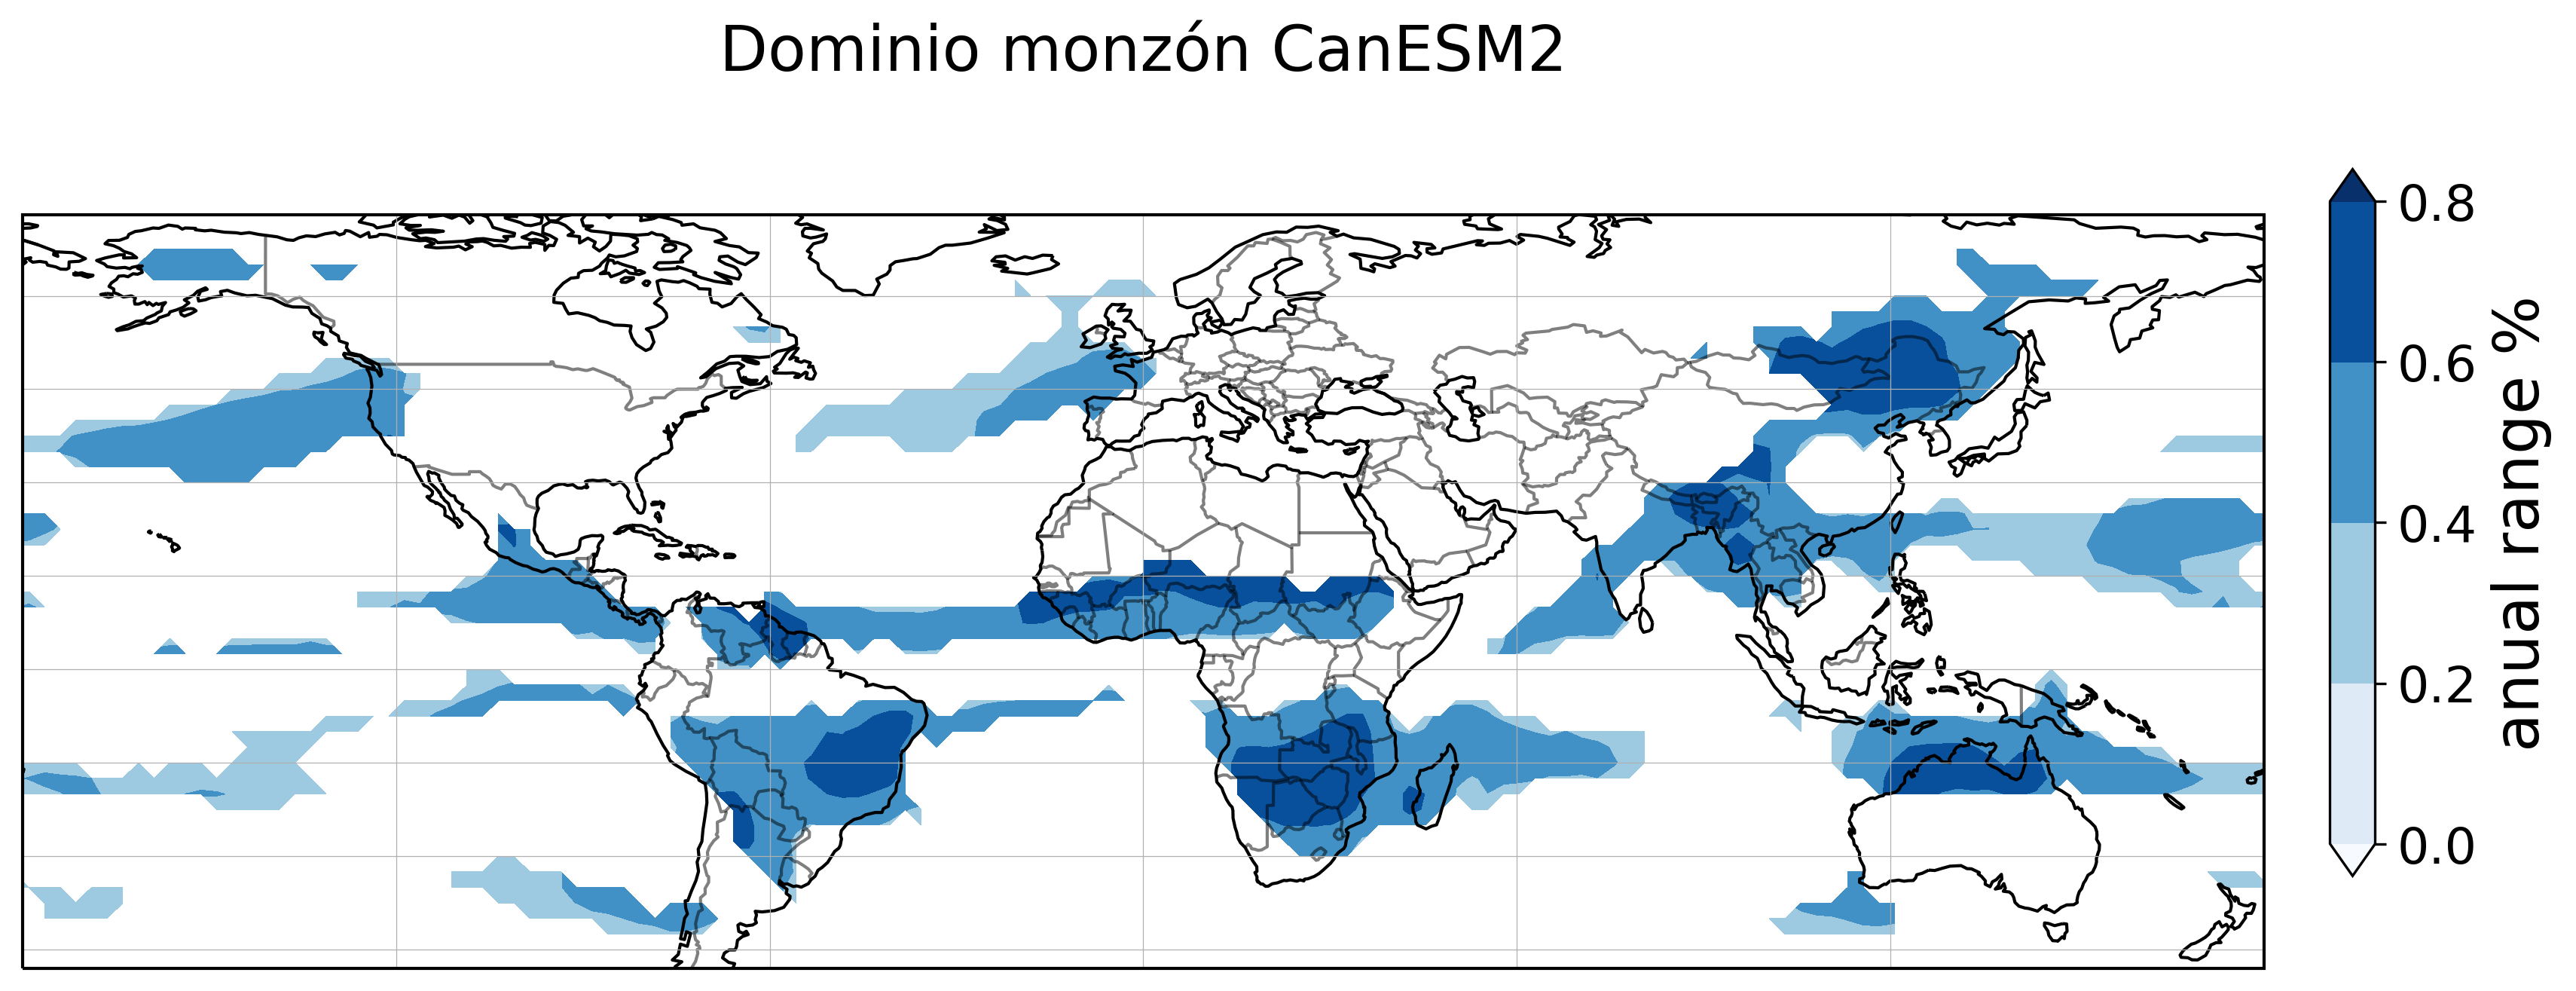

In [204]:
titulo = 'Dominio monzón CanESM2'
lat = CanESM2_ens.lat
mapa(cyclic_range_HS,cyclic_range_HN,titulo)
plt.savefig(path+'dominio_monzon_CanESM2.png',bbox_inches='tight')
plt.clf

Genero mascara para el dominio del monzon

In [127]:
monzon_mask_HS = (mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)/mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)) * (p_verano_HS.where(p_verano_HS > .35)/p_verano_HS.where(p_verano_HS > .35))
monzon_mask_HN = (mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)/mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)) * (p_verano_HN.where(p_verano_HN > .35)/p_verano_HN.where(p_verano_HN > .35))


Mapa de precipitacion

In [182]:
#Genero un mapa para la precipitacion 
def mapa_colores(dato1,dato2,titulo,clevels):
    #America del sur -------Observaciones-----------------------------------------
    fig = plt.figure(figsize=(10, 18),dpi=300,constrained_layout=True)
    fig_size = plt.rcParams["figure.figsize"]
    data_crs = ccrs.PlateCarree(central_longitude=0)
    projection = ccrs.PlateCarree()
    ax1 = plt.subplot(1,1,1,projection=projection)
    clevels = clevels
    im1=ax1.contourf(cyclic_lons, lat, dato1,clevels,transform=data_crs,cmap='Blues',extend='both')
    im2=ax1.contourf(cyclic_lons, lat, dato2,clevels,transform=data_crs,cmap='Blues',extend='both')
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    ax1.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
    #ax1.set_title('Annual range')
    #Saco las coordenadas de la figura hasta ahora
    plt0_ax = plt.gca()
    left, bottom1, width, height = plt0_ax.get_position().bounds
    first_plot_left = plt0_ax.get_position().bounds[0]
    #Utilizo las coordenadas para definir la posición de la colorbar 1
    colorbar_axes = fig.add_axes([first_plot_left + .9, bottom1, 0.02, 1.2*height])
    fig_size[0] = width*4 + 10
    fig_size[1] = height*2 + 3
    plt.rcParams["figure.figsize"] = fig_size
    fig.suptitle(str(titulo), y=0.62, x=0.5,fontsize=20)
    cbar = plt.colorbar(im2, colorbar_axes, fraction=0.05, pad=0.04,aspect=18, orientation='vertical')
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=16)
    cbar.set_label('verano [mm/mes] ',fontsize=20)
    return fig


Enmascaro el los datos de precipitacion y miro el verano

In [179]:
HS_monson = CanESM2_ens.pr*monzon_mask_HS
HS_hist = HS_monson.sel(time=HS_monson['time.season']=='DJF').mean(dim='time')
cyclic_data_HS, cyclic_lons = add_cyclic_point(HS_hist, coord=lon)
HN_monson = CanESM2_ens.pr*monzon_mask_HN
HN_hist = HN_monson.sel(time=HN_monson['time.season']=='JJA').mean(dim='time')
cyclic_data_HN, cyclic_lons = add_cyclic_point(HN_hist, coord=lon)

/home/tabu/anaconda3/envs/juliapy/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tabu/anaconda3/envs/juliapy/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


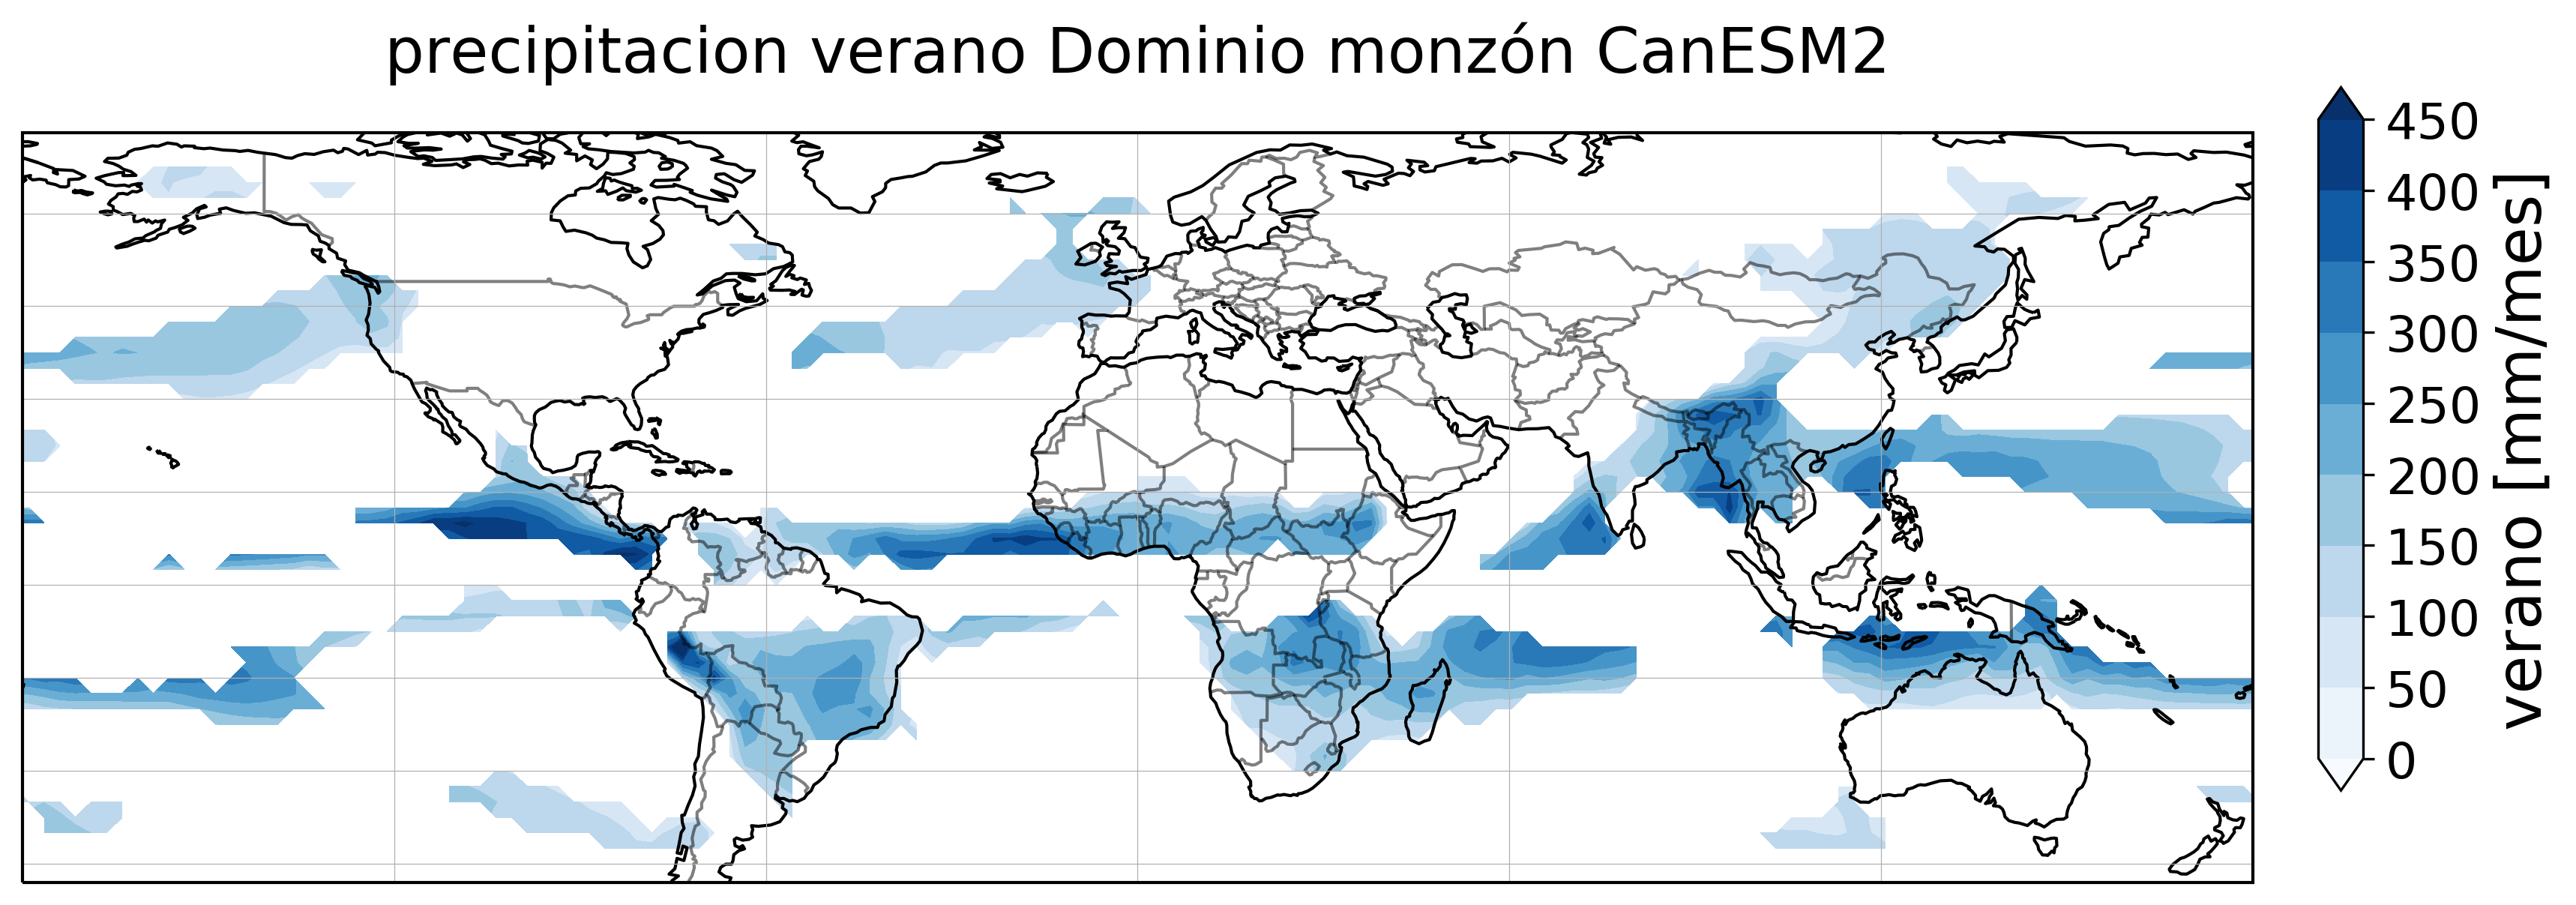

In [199]:
titulo = 'precipitacion verano Dominio monzón CanESM2'
clevels = np.arange(0,500,50)
figura = mapa_colores(cyclic_data_HS,cyclic_data_HN,titulo,clevels)

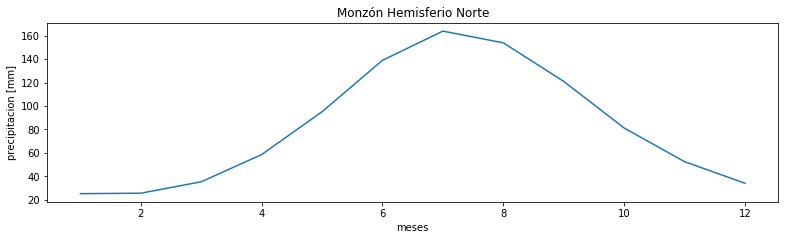

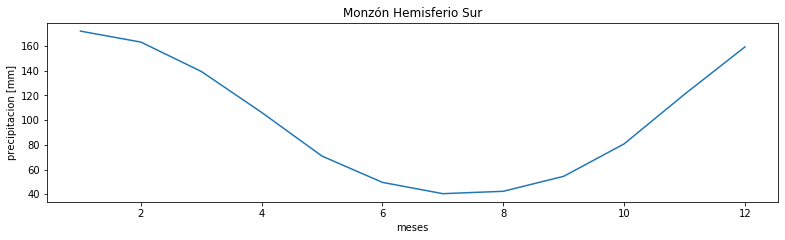

In [134]:

#Calculo el ciclo anual
monson_HS = HS_monson.mean(dim='lon').mean(dim='lat').groupby("time.month").mean("time")
monson_HN = HN_monson.mean(dim='lon').mean(dim='lat').groupby("time.month").mean("time")
meses = monson_HN.month
plt.plot(meses,monson_HN)
plt.xlabel('meses')
plt.ylabel('precipitacion [mm]')
plt.title('Monzón Hemisferio Norte')
#plt.savefig(path+'ciclo_anual_HN_CanESM2.png',bbox_inches='tight')
plt.show()
plt.plot(meses,monson_HS)
plt.xlabel('meses')
plt.ylabel('precipitacion [mm]')
plt.title('Monzón Hemisferio Sur')
#plt.savefig(path+'ciclo_anual_HS_CanESM2.png',bbox_inches='tight')
plt.show()


## Cambios a futuro

In [173]:
#Datos-----------------------------------------------------------------
path = '/home/tabu/Escritorio/Doctorado/ClimDinam/TP2/'
path2 = '/media/tabu/JULIAexterno/climatologia_dinamica/'

#Abro CanESM2 horizonte 1
CanESM2_ens_h1 = xr.open_dataset(path2+'CanESM2/pr_Amon_CanESM2_rcp26_ensmean_202001-204912_2.5_mes.nc')

#Abro CanESM2 horizonte 2
CanESM2_ens_h2 = xr.open_dataset(path2+'CanESM2/pr_Amon_CanESM2_rcp26_ensmean_207001-209912_2.5_mes.nc')

### Horizonte 2020-2049

<function matplotlib.pyplot.clf()>

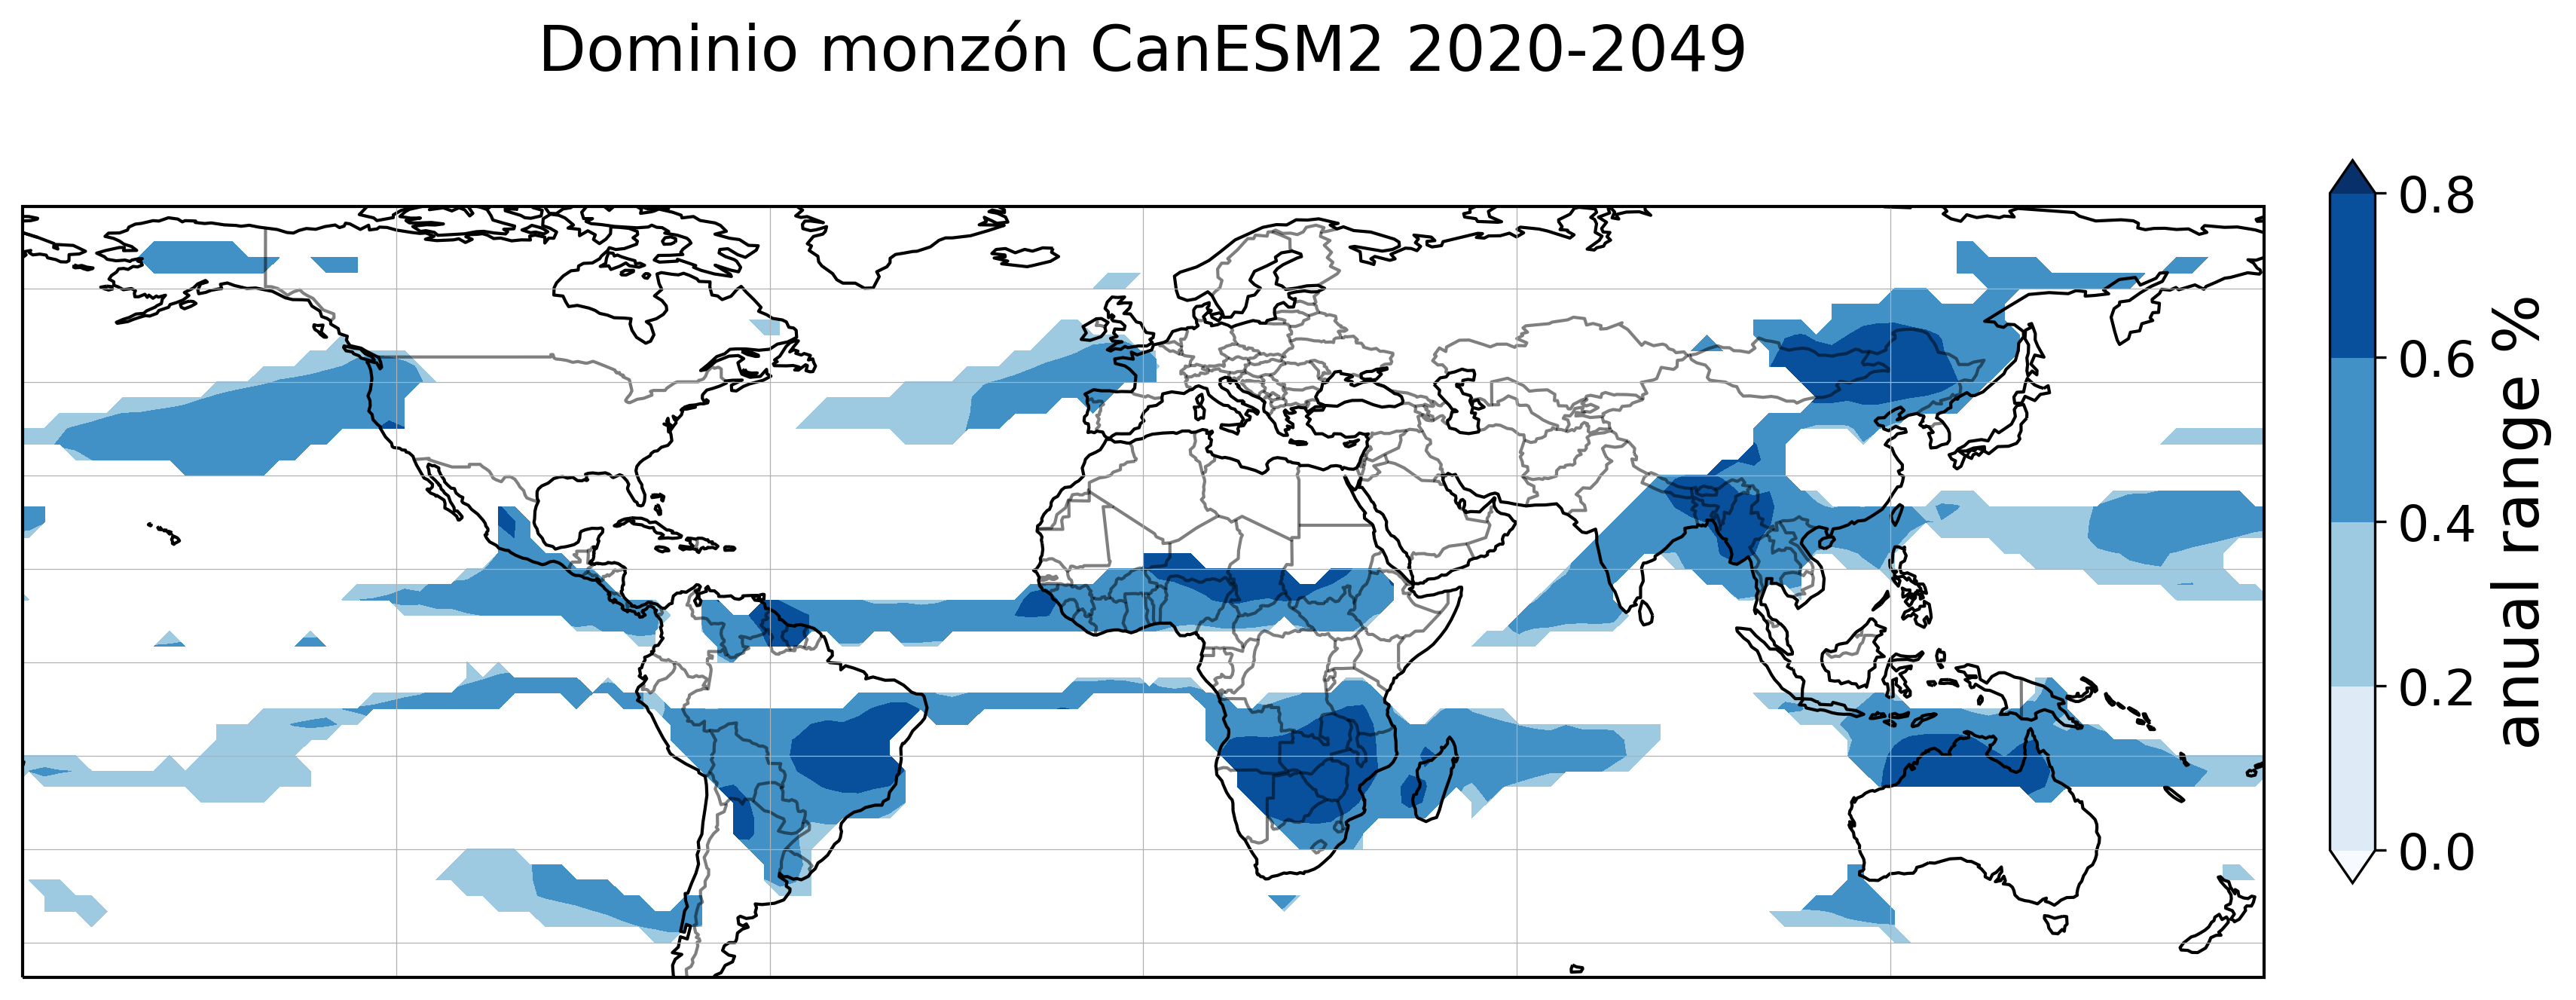

In [205]:
mon_range_CanESM2_HS, p_verano_HS = annual_range_HS(CanESM2_ens_h1)
monzon_range_HS = (mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)/mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)) * p_verano_HS.where(p_verano_HS > .35)

mon_range_CanESM2_HN, p_verano_HN = annual_range_HN(CanESM2_ens_h1)
monzon_range_HN = (mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)/mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)) * p_verano_HN.where(p_verano_HN > .35)

monzon_mask_HS_h1 = (mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)/mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)) * (p_verano_HS.where(p_verano_HS > .35)/p_verano_HS.where(p_verano_HS > .35))
monzon_mask_HN_h1 = (mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)/mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)) * (p_verano_HN.where(p_verano_HN > .35)/p_verano_HN.where(p_verano_HN > .35))

lon = np.arange(0, 362, 362/144)
lat = CanESM2_ens.lat
cyclic_range_HN_h1, cyclic_lons = add_cyclic_point(monzon_range_HN, coord=lon)
cyclic_range_HS_h1, cyclic_lons = add_cyclic_point(monzon_range_HS, coord=lon)

titulo = 'Dominio monzón CanESM2 2020-2049'
lat = CanESM2_ens.lat
mapa(cyclic_range_HS_h1,cyclic_range_HN_h1,titulo)
#plt.savefig(path+'dominio_monzon_CanESM2.png',bbox_inches='tight')
plt.clf

Genero mascara para el horizonte 2020-2070

In [188]:
HS_monson = CanESM2_ens_h1.pr*monzon_mask_HS_h1
HS_h1 = HS_monson.sel(time=HS_monson['time.season']=='DJF').mean(dim='time')
cyclic_data_HS_h1, cyclic_lons = add_cyclic_point(HS_h1, coord=lon)
HN_monson = CanESM2_ens_h1.pr*monzon_mask_HN_h1
HN_h1 = HN_monson.sel(time=HN_monson['time.season']=='JJA').mean(dim='time')
cyclic_data_HN_h1, cyclic_lons = add_cyclic_point(HN_h1, coord=lon)

/home/tabu/anaconda3/envs/juliapy/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tabu/anaconda3/envs/juliapy/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


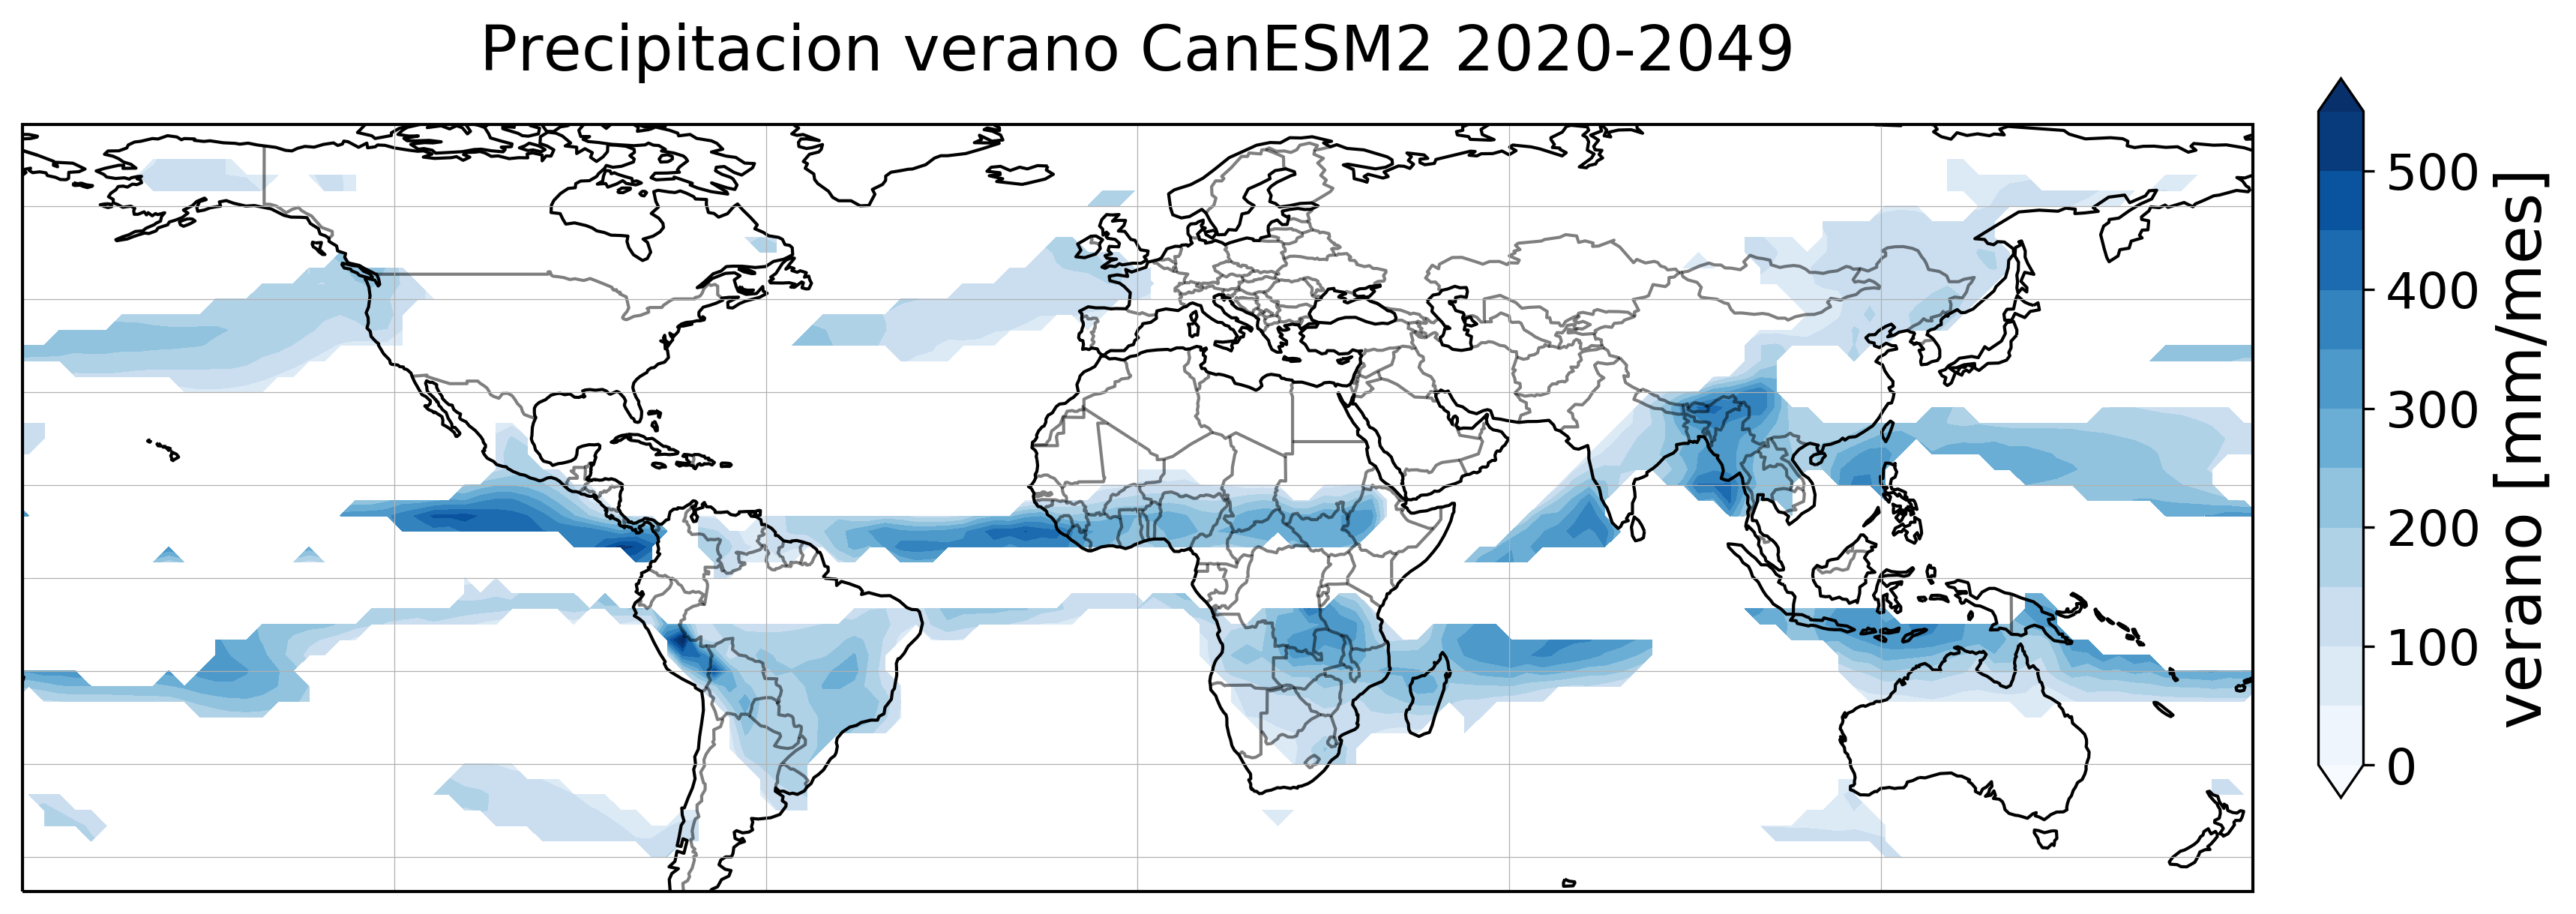

In [202]:
titulo = 'Precipitacion verano CanESM2 2020-2049'
clevels = np.arange(0,600,50)
figura = mapa_colores(cyclic_data_HS_h1,cyclic_data_HN_h1,titulo,clevels)

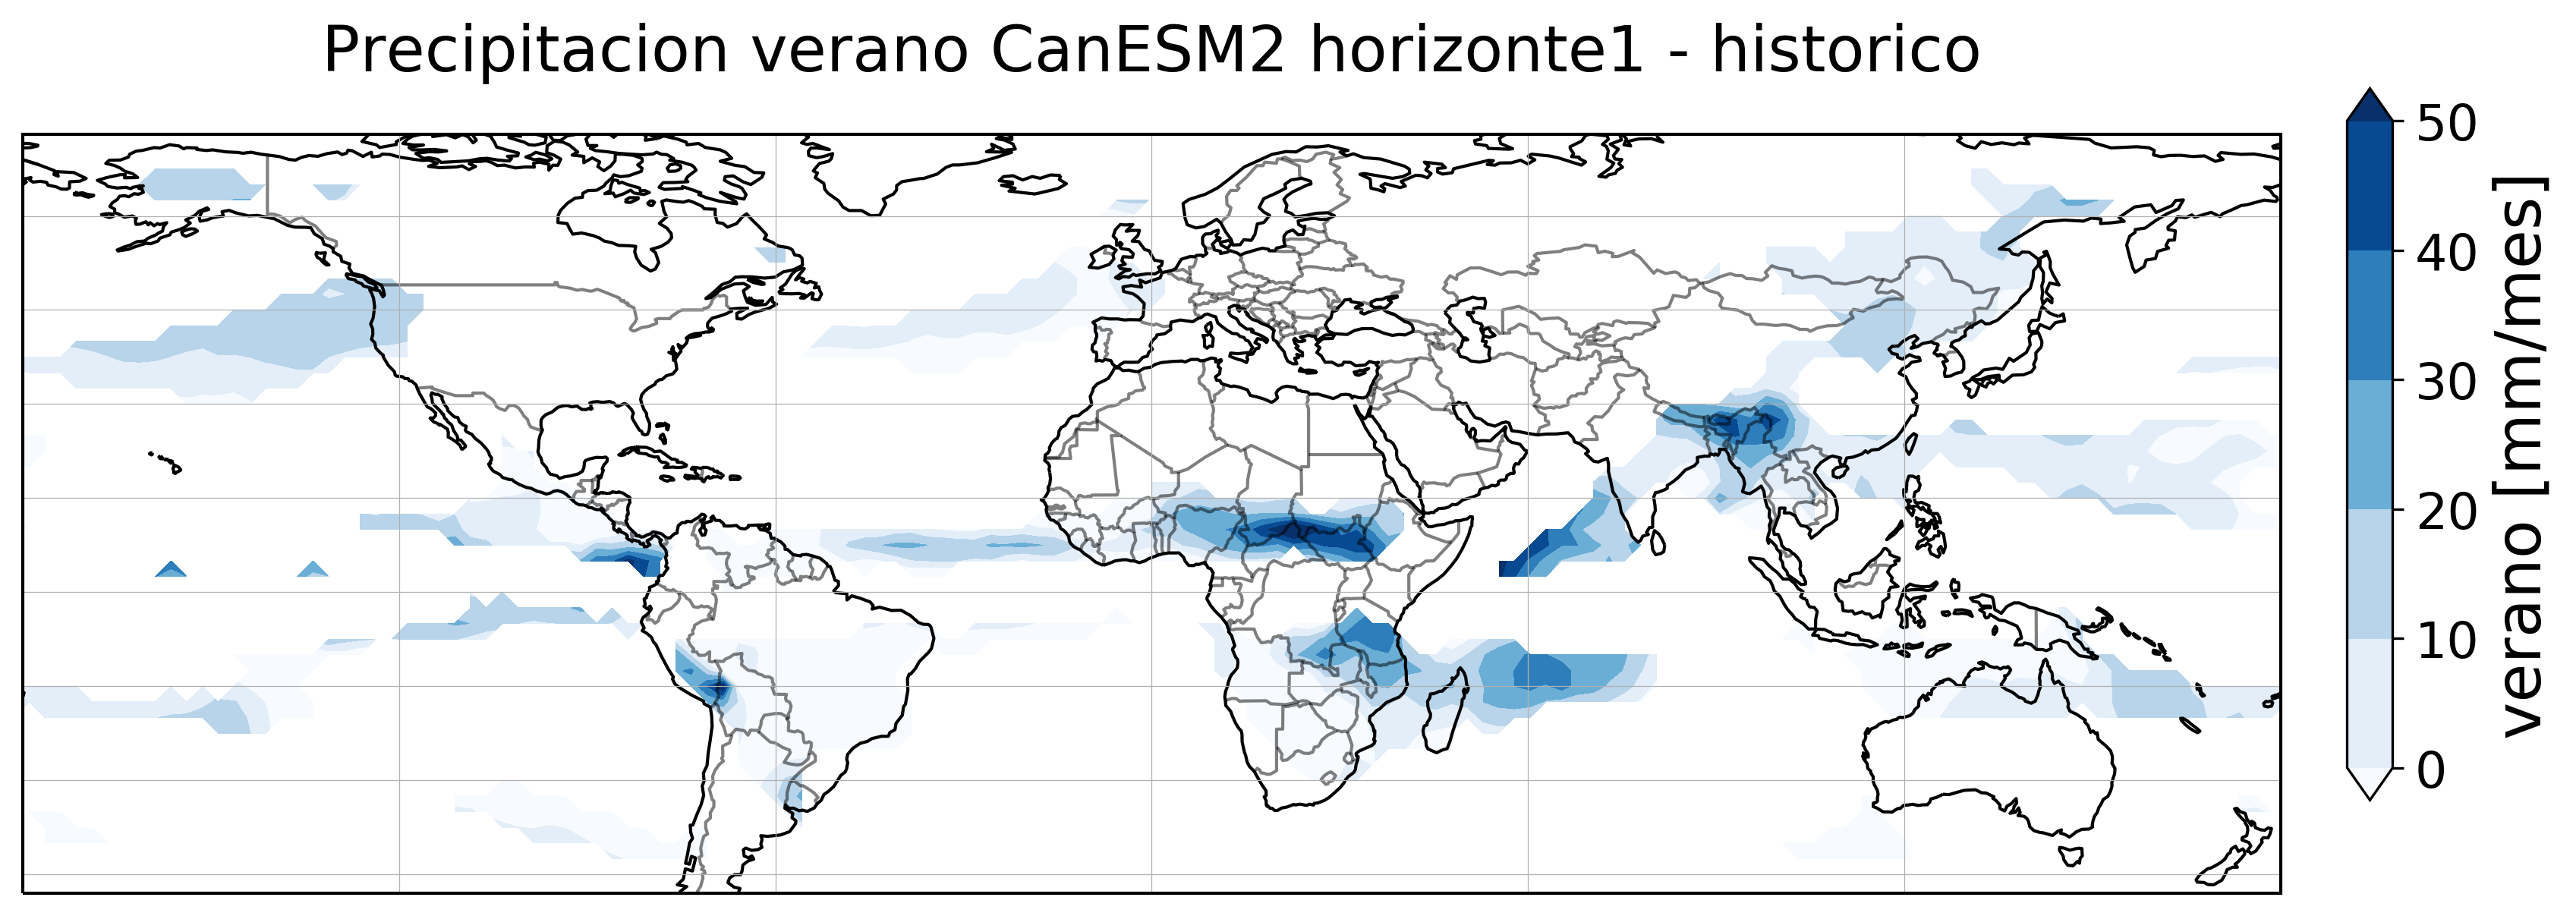

In [201]:
titulo = 'Precipitacion verano CanESM2 horizonte1 - historico'
clevels = np.arange(0,60,10)
figura = mapa_colores(cyclic_data_HS_h1 - cyclic_data_HS,cyclic_data_HN_h1 -cyclic_data_HN,titulo,clevels)

###  Horizonte 2 2070-2099

<function matplotlib.pyplot.clf()>

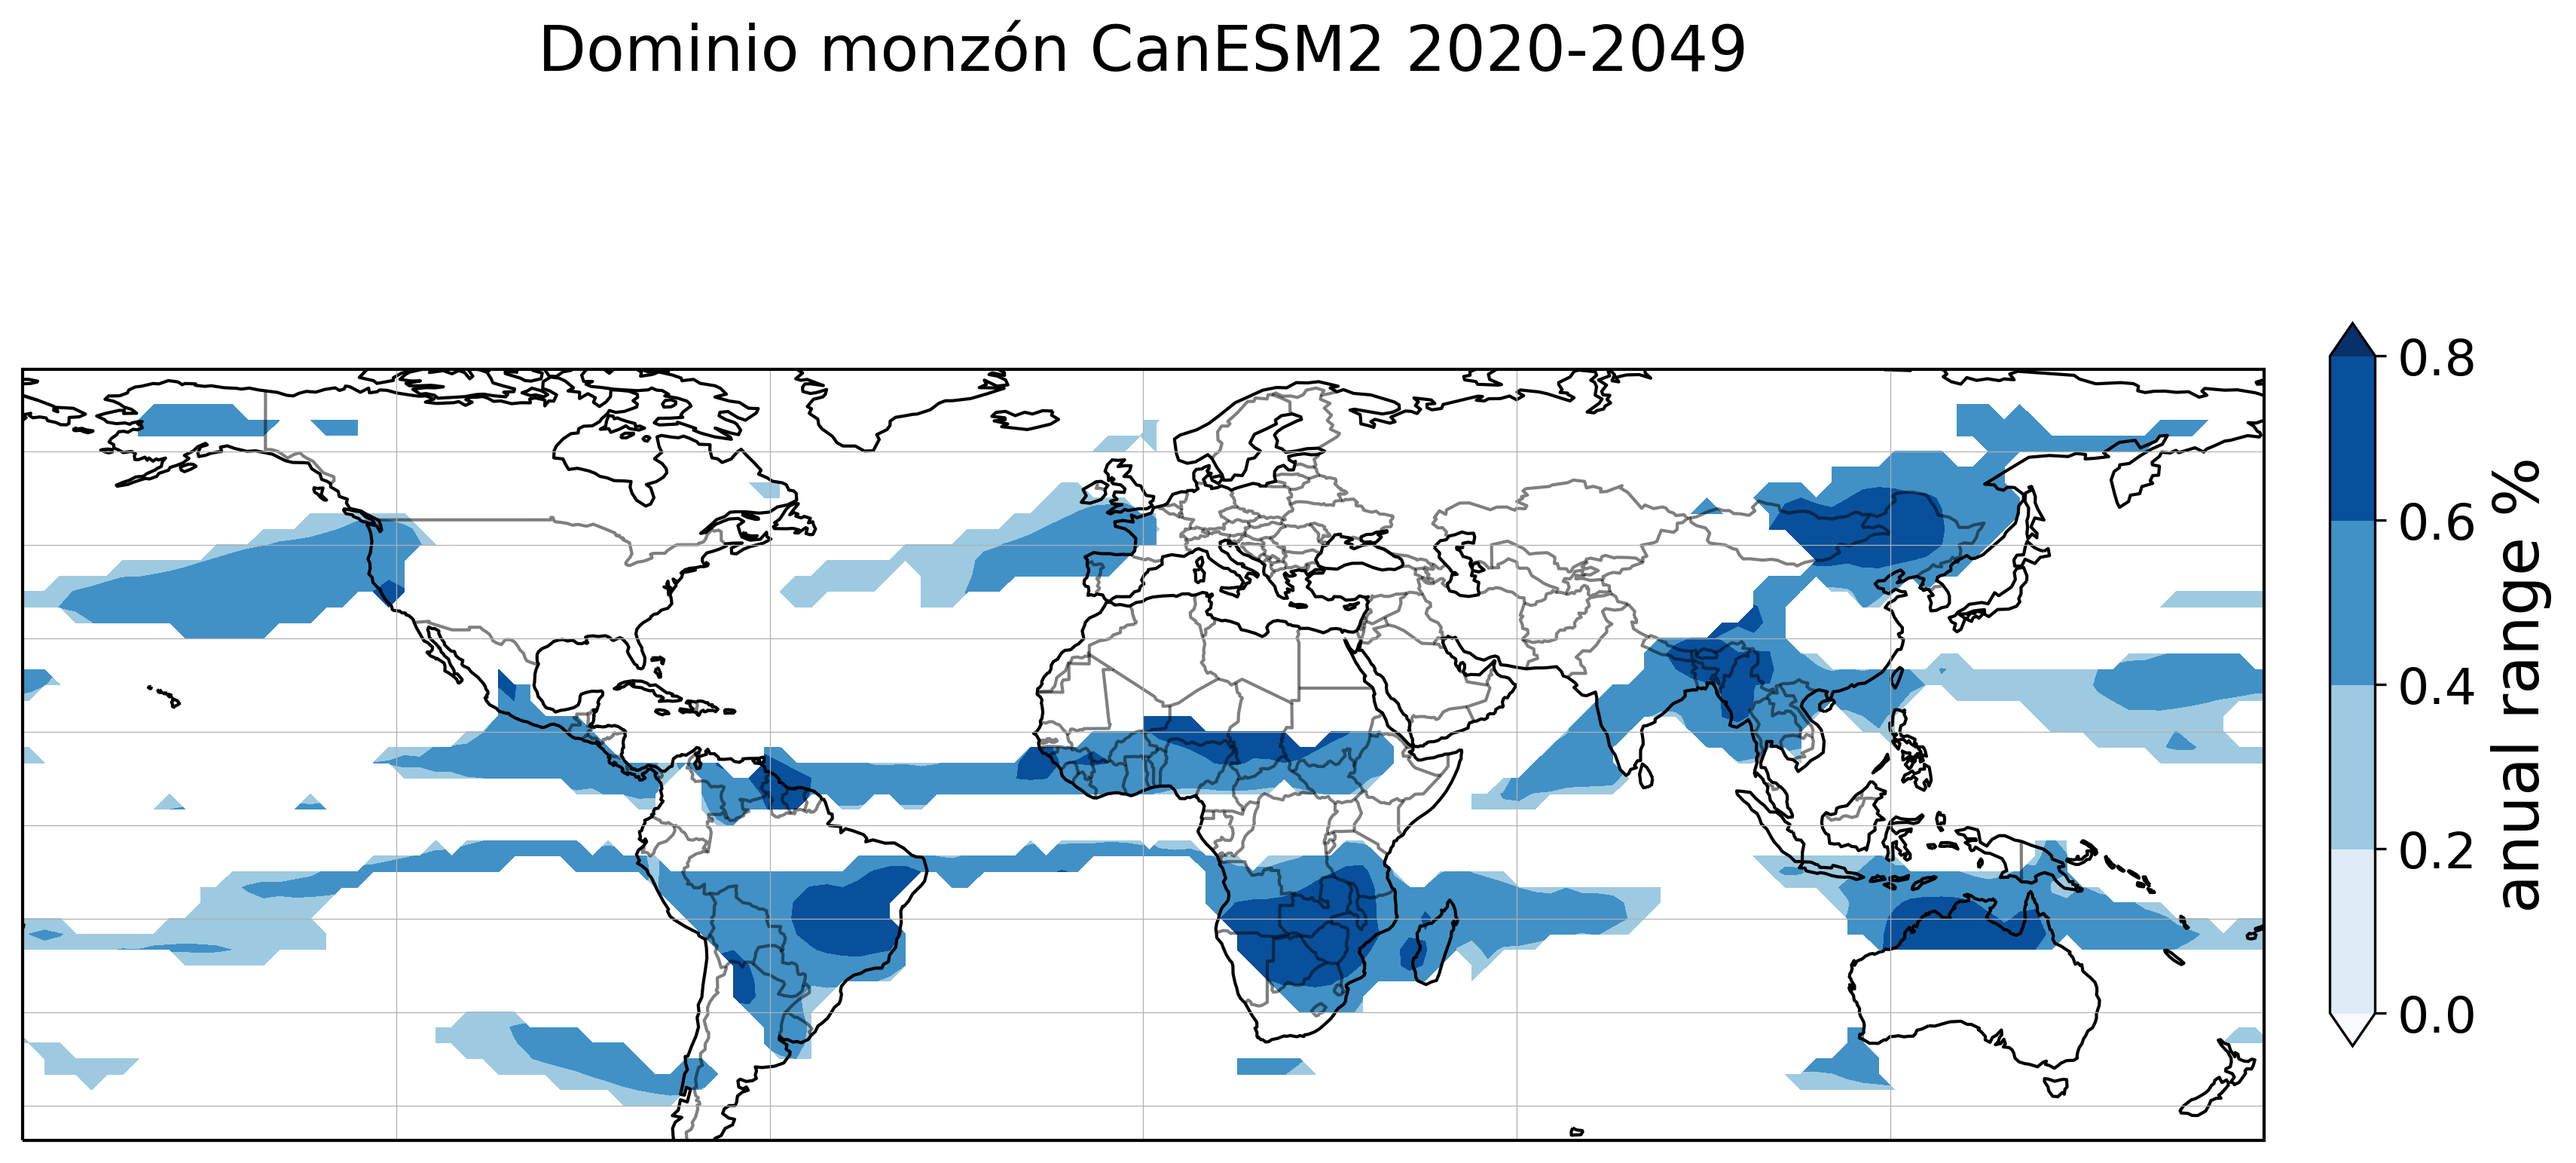

In [193]:
mon_range_CanESM2_HS, p_verano_HS = annual_range_HS(CanESM2_ens_h2)
monzon_range_HS = (mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)/mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)) * p_verano_HS.where(p_verano_HS > .35)

mon_range_CanESM2_HN, p_verano_HN = annual_range_HN(CanESM2_ens_h2)
monzon_range_HN = (mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)/mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)) * p_verano_HN.where(p_verano_HN > .35)

monzon_mask_HS_h2 = (mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)/mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)) * (p_verano_HS.where(p_verano_HS > .35)/p_verano_HS.where(p_verano_HS > .35))
monzon_mask_HN_h2 = (mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)/mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)) * (p_verano_HN.where(p_verano_HN > .35)/p_verano_HN.where(p_verano_HN > .35))

lon = np.arange(0, 362, 362/144)
lat = CanESM2_ens.lat
cyclic_range_HN_h2, cyclic_lons = add_cyclic_point(monzon_range_HN, coord=lon)
cyclic_range_HS_h2, cyclic_lons = add_cyclic_point(monzon_range_HS, coord=lon)

titulo = 'Dominio monzón CanESM2 2020-2049'
lat = CanESM2_ens.lat
mapa(cyclic_range_HS_h2,cyclic_range_HN_h2,titulo)
#plt.savefig(path+'dominio_monzon_CanESM2.png',bbox_inches='tight')
plt.clf

In [213]:
HS_monson_h2 = CanESM2_ens_h2.pr*monzon_mask_HS_h2
HS_h2 = HS_monson_h2.sel(time=HS_monson_h2['time.season']=='DJF').mean(dim='time')
cyclic_data_HS_h2, cyclic_lons = add_cyclic_point(HS_h2, coord=lon)
HN_monson_h2 = CanESM2_ens_h2.pr*monzon_mask_HN_h2
HN_h2 = HN_monson_h2.sel(time=HN_monson_h2['time.season']=='JJA').mean(dim='time')
cyclic_data_HN_h2, cyclic_lons = add_cyclic_point(HN_h2, coord=lon)

/home/tabu/anaconda3/envs/juliapy/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tabu/anaconda3/envs/juliapy/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


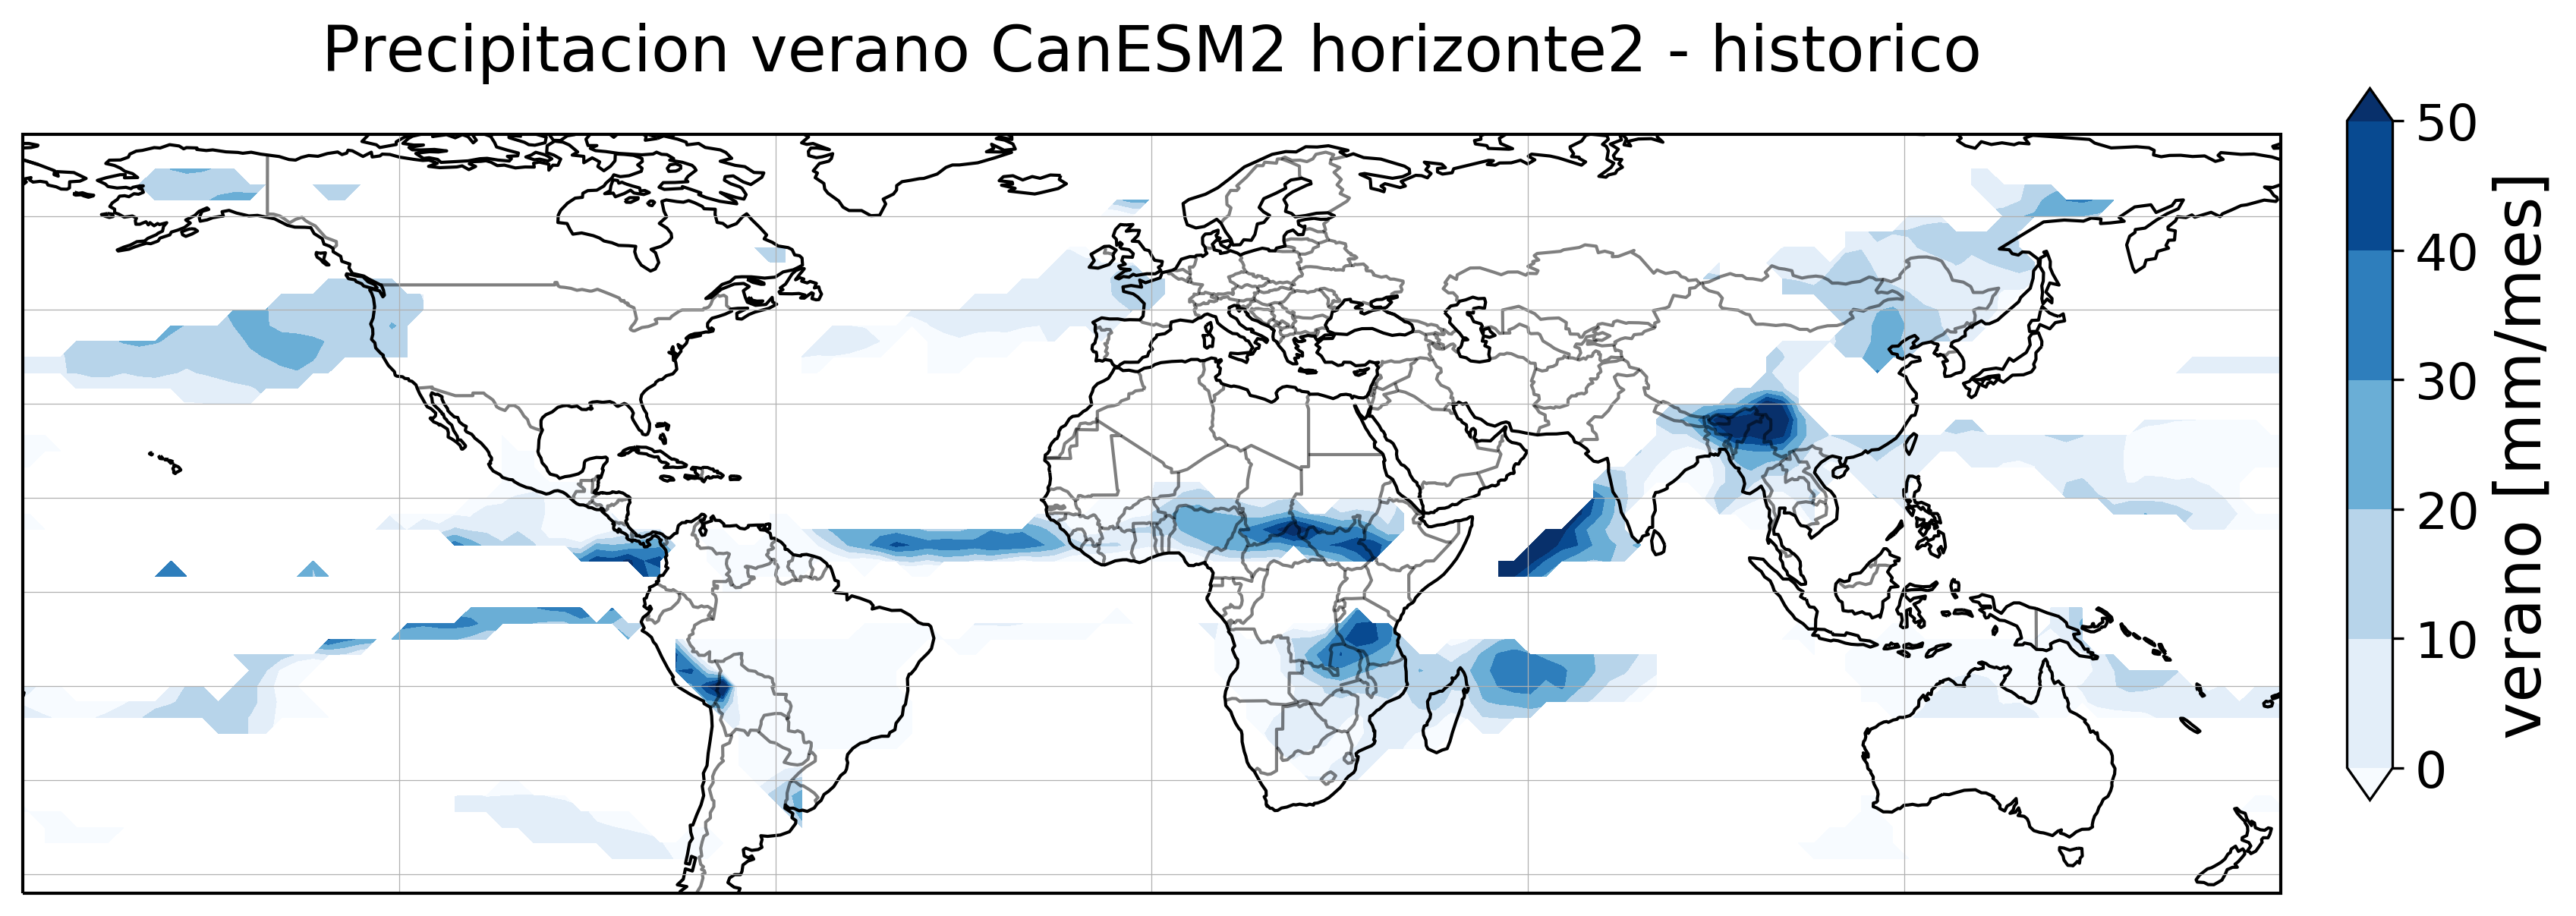

In [212]:
titulo = 'Precipitacion verano CanESM2 horizonte2 - historico'
clevels = np.arange(0,60,10)
figura = mapa_colores(cyclic_data_HS_h2 - cyclic_data_HS,cyclic_data_HN_h2 -cyclic_data_HN,titulo,clevels)

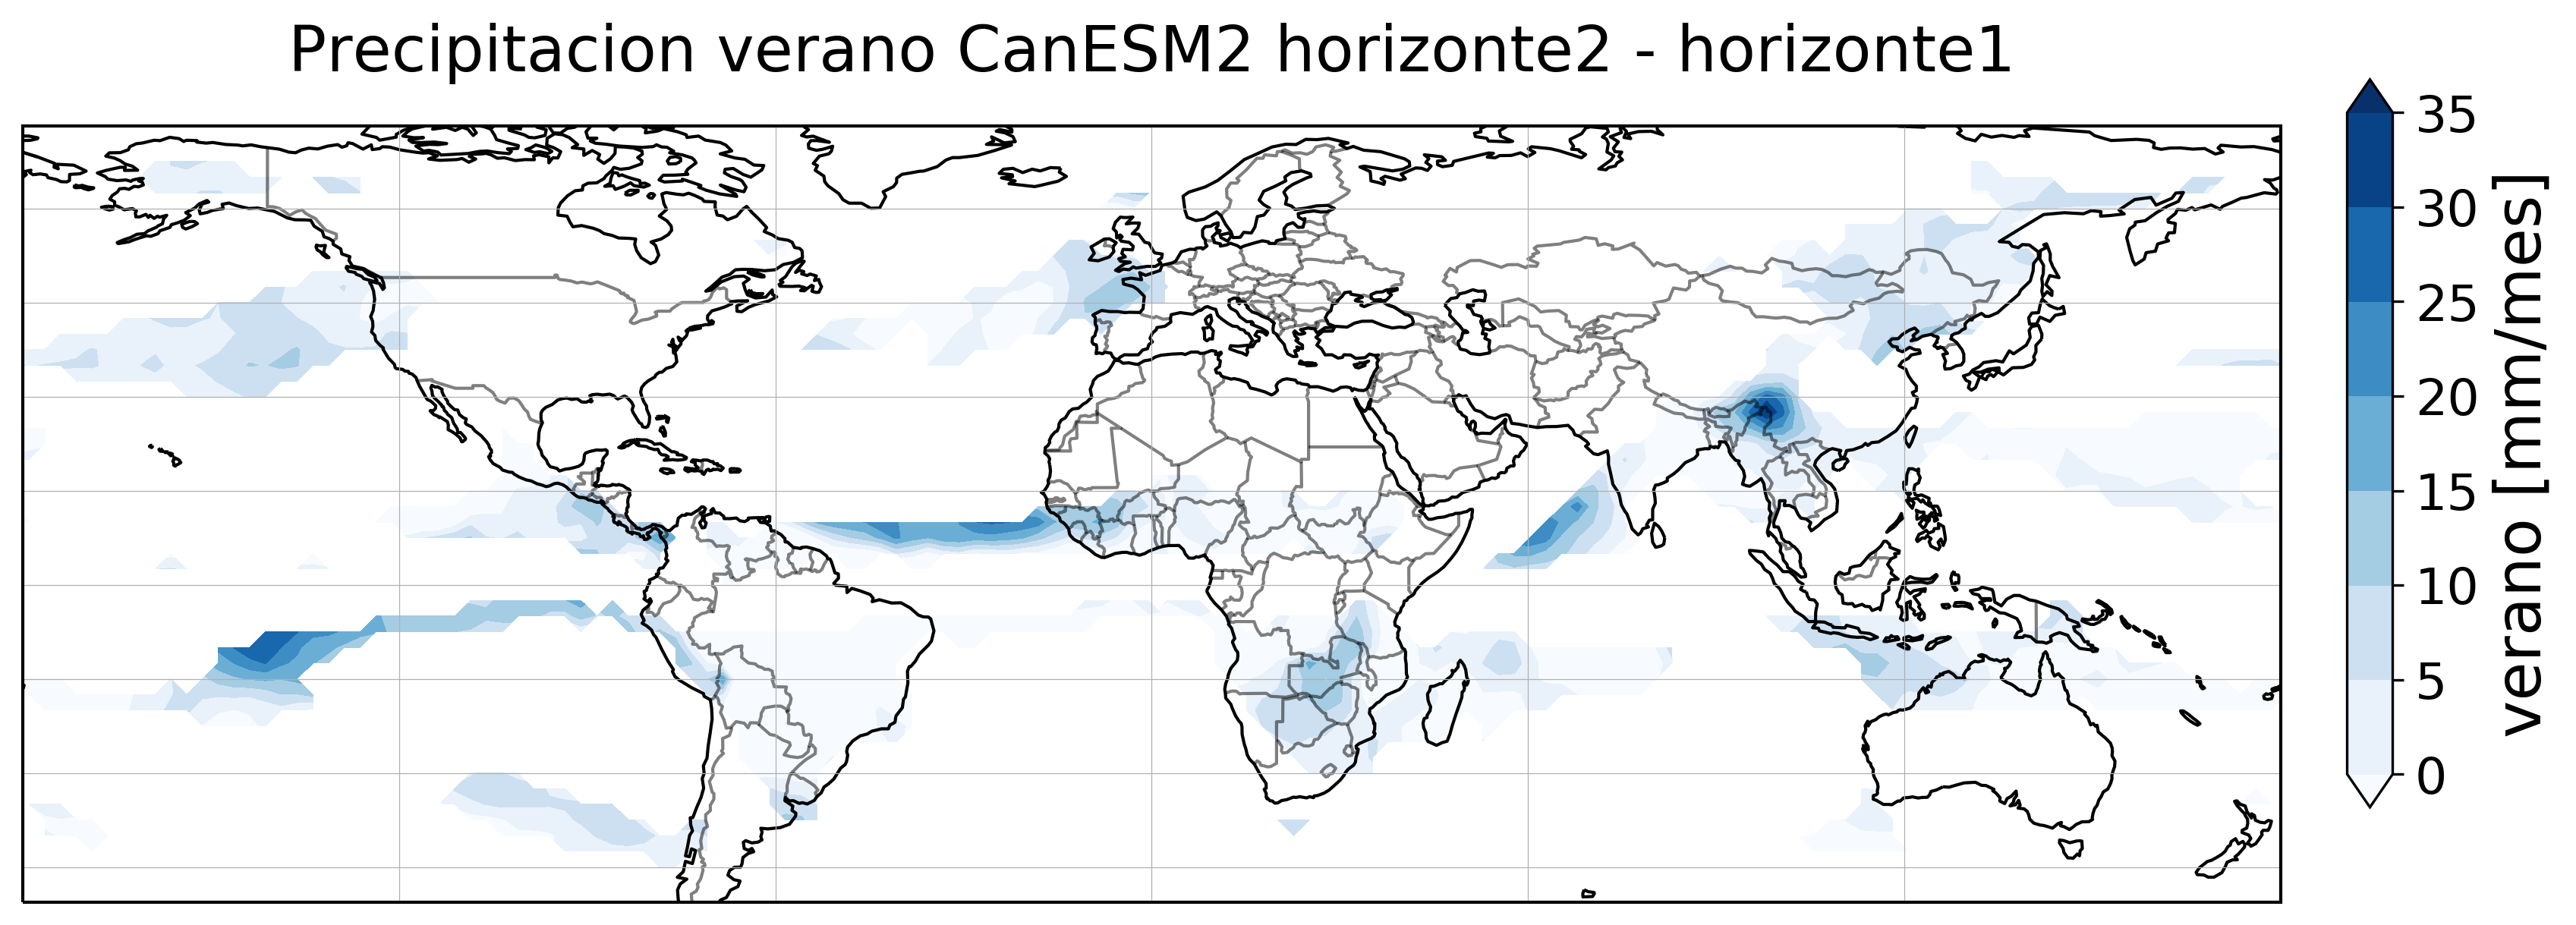

In [210]:
titulo = 'Precipitacion verano CanESM2 horizonte2 - horizonte1'
clevels = np.arange(0,40,5)
figura = mapa_colores(cyclic_data_HS_h2 - cyclic_data_HS_h1,cyclic_data_HN_h2 -cyclic_data_HN_h1,titulo,clevels)

Lo que veo es que entre el período histórico y el primer horizonte hay un cambio mucho más grande que entre el primer horizonte y el segundo horizonte (a fin de siglo). Eso me llama la atención. Lo segundo que me parece interesante es que hay una mayor extensión hacia el sur del monzón africano entre el horizonte 1 y el horizonte 2. Por eso me voy a concentrar en este monzón (además seguro la mayoría mira India o Sudamérica) y voy a analizar si la ventilación puede decir algo sobre esto.  

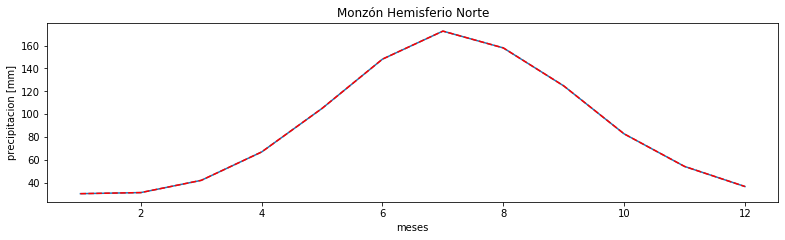

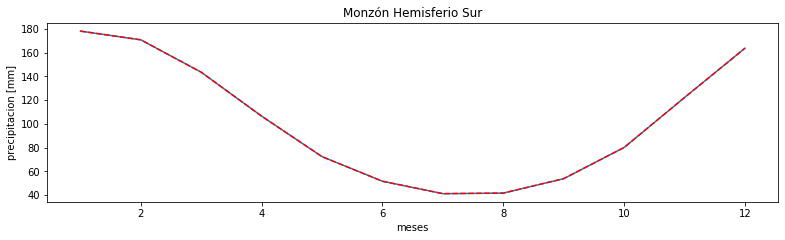

In [218]:

#Calculo el ciclo anual
monson_HS = HS_monson.mean(dim='lon').mean(dim='lat').groupby("time.month").mean("time")
monson_HN = HN_monson.mean(dim='lon').mean(dim='lat').groupby("time.month").mean("time")
monson_HS_h2 = HS_monson_h2.mean(dim='lon').mean(dim='lat').groupby("time.month").mean("time")
monson_HN_h2 = HN_monson_h2.mean(dim='lon').mean(dim='lat').groupby("time.month").mean("time")
meses = monson_HN.month
plt.plot(meses,monson_HN,label='historico')
plt.plot(meses,monson_HN_h2,'--r',label='horizonte 2')
plt.xlabel('meses')
plt.ylabel('precipitacion [mm]')
plt.title('Monzón Hemisferio Norte')
#plt.savefig(path+'ciclo_anual_HN_CanESM2.png',bbox_inches='tight')
plt.show()
plt.plot(meses,monson_HS,label='historico')
plt.plot(meses,monson_HS_h2,'--r',label='horizonte 2')
plt.xlabel('meses')
plt.ylabel('precipitacion [mm]')
plt.title('Monzón Hemisferio Sur')
#plt.savefig(path+'ciclo_anual_HS_CanESM2.png',bbox_inches='tight')
plt.show()


## CanESM5 Abro los datos de viento 


In [174]:
#Abro CanESM5 historico
u850 = xr.open_dataset(path2+'CanESM5/ua850_Amon_CanESM5_historical_ensmeani1p1f1_2.5.nc')

v850 = xr.open_dataset(path2+'CanESM5/va850_Amon_CanESM5_historical_ensmeani1p1f1_2.5.nc')

#Abro CanESM5 viento horizonte 1
u850_h1 = xr.open_dataset(path2+'CanESM5/ua850_Amon_CanESM5_ssp585_r1i1p1f1_2020-2049_2.5.nc')

v850_h1 = xr.open_dataset(path2+'CanESM5/va850_Amon_CanESM5_ssp585_r1i1p1f1_2020-2049_2.5.nc')

#Abro CanESM5 viento horizonte 2
u850_h2 = xr.open_dataset(path2+'CanESM5/ua850_Amon_CanESM5_ssp585_r1i1p1f1_2070-2099_2.5.nc')

v850_h2 = xr.open_dataset(path2+'CanESM5/va850_Amon_CanESM5_ssp585_r1i1p1f1_2070-2099_2.5.nc')

lon = np.arange(-180,180, 362/144)
lon_attrs = u850.lon.attrs
u850['lon'] = lon
u850['lon'].attrs = lon_attrs
v850['lon'] = lon
v850['lon'].attrs = lon_attrs

In [192]:
def vientos(shape=(20, 30)):
    """
    Returns ``(x, y, u, v, crs)`` of some vector data
    computed mathematically. The returned CRS will be a North Polar
    Stereographic projection, meaning that the vectors will be unevenly
    spaced in a PlateCarree projection.

    """
    crs = ccrs.PlateCarree()
    scale = 1e9
    x = np.linspace(scale, scale, shape[0])
    y = np.linspace(scale, scale, shape[1])

    x2d, y2d = np.meshgrid(x, y)
    u = u850.sel(plev=85000).sel(time=u850['time.season']=='DJF').mean(dim='time').ua.values - u850.sel(plev=85000).sel(time=u850['time.season']=='JJA').mean(dim='time').ua.values
    v = v850.sel(plev=85000).sel(time=v850['time.season']=='DJF').mean(dim='time').va.values - v850.sel(plev=85000).sel(time=v850['time.season']=='JJA').mean(dim='time').va.values
    return x, y, u, v, crs


def main():
    plt.figure(figsize=(8, 10))
    lat = u850.lat
    lon = u850.lon
    x, y, u, v, vector_crs = vientos(shape=(len(lon),len(lat)))

    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    plt.title('DJF - JJA')
    ax.coastlines('50m')
    ax.set_extent([-100,60, -70, 20], ccrs.PlateCarree())
    ax.quiver(lon,lat, u, v, transform=ccrs.PlateCarree(), regrid_shape=15)

    plt.show()


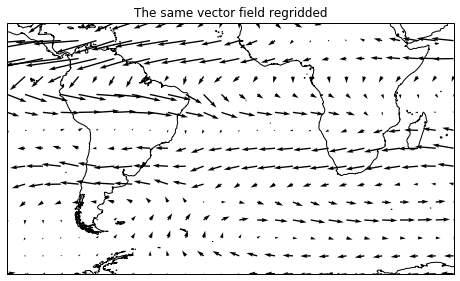

In [191]:
main()

In [67]:
x, y, u, v, vector_crs = sample_data(shape=(len(lon),len(lat)))

In [322]:
#Abro CanESM5 historico
tas = xr.open_dataset(path2+'CanESM5/tas_Amon_CanESM5_historical_ensmeani1p1f1_2.5.nc')
#Abro CanESM5 viento horizonte 1
tas_h1 = xr.open_dataset(path2+'CanESM5/tas_Amon_CanESM5_ssp585_ensmeani1p1f1_2020-2049_2.5.nc')
#Abro CanESM5 viento horizonte 2
tas_h2 = xr.open_dataset(path2+'CanESM5/tas_Amon_CanESM5_ssp585_ensmeani1p1f1_2070-2099_2.5.nc')

lon = np.arange(-180,180, 362/144)
lon_attrs = u850.lon.attrs
tas['lon'] = lon
tas['lon'].attrs = lon_attrs
tas_h1['lon'] = lon
tas_h1['lon'].attrs = lon_attrs
tas_h2['lon'] = lon
tas_h2['lon'].attrs = lon_attrs
lat = tas.lat

Gradiente de T 

In [289]:
tas_x = tas.tas.differentiate(coord='lon').mean(dim='time')
tas_y = tas.tas.differentiate(coord='lat').mean(dim='time')

In [311]:
0.5*111000

55500.0

In [323]:
def derivada():
    for i in range(len(lat)):
        for j in range(len(lon)-2):
            dato = tas.tas.sel(time=tas['time.season']=='DJF').mean(dim='time').isel(lat=i)
            tas_x[i,j] =  ((dato.isel(lon=j+1) - dato.isel(lon=j)))/55500
            
            

In [326]:
tas_x = derivada()

TypeError: 'NoneType' object does not support item assignment

360.5

In [202]:
tas_x = tas.tas.differentiate(coord='lon')
tas_y = tas.tas.differentiate(coord='lat')

In [213]:
huss = xr.open_dataset(path2+'CanESM5/huss_Amon_CanESM5_historical_ensmeani1p1f1_2.5.nc')

huss_h1 = xr.open_dataset(path2+'CanESM5/huss_Amon_CanESM5_ssp585_r1i1p1f1_2020-2049_2.5.nc')

huss_h2 = xr.open_dataset(path2+'CanESM5/huss_Amon_CanESM5_ssp585_r1i1p1f1_2070-2099_2.5.nc')
huss['lon'] = lon
huss['lon'].attrs = lon_attrs
huss_h1['lon'] = lon
huss_h1['lon'].attrs = lon_attrs
huss_h2['lon'] = lon
huss_h2['lon'].attrs = lon_attrs

In [214]:
huss_x = huss.huss.differentiate(coord='lon')
huss_y = huss.huss.differentiate(coord='lat')

In [261]:
adv_T = u*tas_x.sel(time=tas_x['time.season']=='DJF').mean(dim='time') + v*tas_y.sel(time=tas_y['time.season']=='DJF').mean(dim='time')

In [263]:
np.min(adv_T)

<xarray.DataArray 'tas' ()>
array(-21.063797)
Coordinates:
    height   float64 2.0

In [270]:
def vientos(shape=(20, 30)):
    """
    Returns ``(x, y, u, v, crs)`` of some vector data
    computed mathematically. The returned CRS will be a North Polar
    Stereographic projection, meaning that the vectors will be unevenly
    spaced in a PlateCarree projection.

    """
    crs = ccrs.PlateCarree()
    scale = 1e9
    x = np.linspace(scale, scale, shape[0])
    y = np.linspace(scale, scale, shape[1])

    x2d, y2d = np.meshgrid(x, y)
    u = u850.sel(plev=85000).sel(time=u850['time.season']=='DJF').mean(dim='time').ua.values
    v = v850.sel(plev=85000).sel(time=v850['time.season']=='DJF').mean(dim='time').va.values
    return x, y, u, v, crs


def map_adv():
    
    fig = plt.figure(figsize=(8, 10))
    lat = tas.lat
    lon = tas.lon
    x, y, u, v, vector_crs = vientos(shape=(len(lon),len(lat)))

    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    plt.title('DJF')
    ax.coastlines('50m')
    ax.set_extent([-100,60, -70, 20], ccrs.PlateCarree())
    ax.quiver(lon,lat, u, v, transform=ccrs.PlateCarree(), regrid_shape=15)
    
    clevels = np.arange(-5,5,1)
    im1=ax.contourf(lon, lat, adv_T,clevels,transform=vector_crs,cmap='RdBu',extend='both') 
    
    ax.gridlines(crs=vector_crs, linewidth=0.3, linestyle='-')
    #Saco las coordenadas de la figura hasta ahora
    plt0_ax = plt.gca()
    left, bottom1, width, height = plt0_ax.get_position().bounds
    first_plot_left = plt0_ax.get_position().bounds[0]
    #Utilizo las coordenadas para definir la posición de la colorbar 1
    colorbar_axes = fig.add_axes([first_plot_left + .9, bottom1, 0.02, 1.2*height])
    cbar = plt.colorbar(im1, colorbar_axes, fraction=0.05, pad=0.04,aspect=18, orientation='vertical')
    #ticklabs = cbar.ax.get_yticklabels()
    #cbar.ax.set_yticklabels(ticklabs, fontsize=16)
    cbar.set_label('v dot $ grad(T) $ ',fontsize=20)

    plt.show()

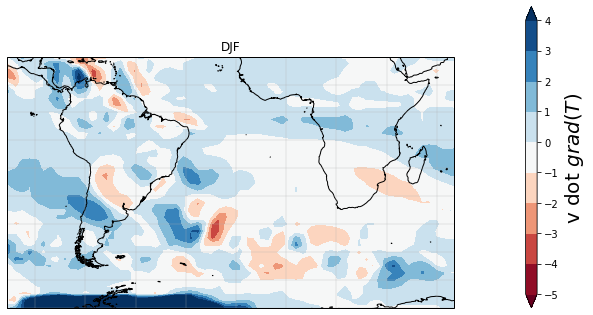

In [271]:
map_adv()